In [71]:
# CartPole
# Discrete Control input
# Actor Critic structure, with tensorflow

# Hope it works

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

n_observation = 4
n_action = 2
n_hidden_c = 10
n_hidden_a = 10

gamma = 0.9

# Critic Network
tf_obs_c = tf.placeholder(tf.float32, [None, n_observation])
# layers
with tf.variable_scope('CriticScope'):
    W1_c = tf.Variable(tf.random_normal([n_observation, n_hidden_c]))
    b1_c = tf.Variable(tf.random_normal([n_hidden_c]))
    W2_c = tf.Variable(tf.random_normal([n_hidden_c, n_action]))
    b2_c = tf.Variable(tf.random_normal([n_action]))
CriticVars = tf.get_collection(tf.GraphKeys.VARIABLES, scope='CriticScope')
    
fc1_c = tf.nn.relu(tf.matmul(tf_obs_c, W1_c) + b1_c)
out_c = tf.matmul(fc1_c, W2_c) + b2_c
# this is not good for batch calculation
outQ_c = tf.reduce_max(out_c)

# training
tf_action = tf.placeholder(tf.int32, [None,1])
tf_targetQ = tf.placeholder(tf.float32, [None,1])
tf_action_onehot = tf.one_hot(tf_action, n_action)
tf_Qsa = tf.reduce_sum(tf.mul(out_c, tf_action_onehot))
# loss
tf_td_error = tf_targetQ - tf_Qsa
loss_c = tf.reduce_mean(tf.square(tf_td_error))
trainer_c = tf.train.AdamOptimizer(0.01).minimize(loss_c, var_list=CriticVars)

# Actor Network
tf_obs_a = tf.placeholder(tf.float32, [None, n_observation])
tf_Qsa_a = tf.placeholder(tf.float32, [None,1])
tf_advantage_a = tf.placeholder(tf.float32, [None, 1])
# layers
with tf.variable_scope('ActorScope'):
    W1_a = tf.Variable(tf.random_normal([n_observation, n_hidden_a]))
    b1_a = tf.Variable(tf.random_normal([n_hidden_a]))
    W2_a = tf.Variable(tf.random_normal([n_hidden_a, n_action]))
    b2_a = tf.Variable(tf.random_normal([n_action]))
ActorVars = tf.get_collection(tf.GraphKeys.VARIABLES, scope='ActorScope')
    
fc1_a = tf.nn.relu(tf.matmul(tf_obs_a, W1_a) + b1_a)
out_a = tf.matmul(fc1_a, W2_a) + b2_a
tf_prob = tf.nn.softmax(out_a)
# training
tf_log_prob = tf.reduce_sum(-tf.log(tf_prob) * tf_action_onehot, 1)
# td_error as the direction
loss_a = tf.reduce_mean(tf.mul(tf_log_prob, tf_advantage_a))
trainer_a = tf.train.AdamOptimizer(0.01).minimize(loss_a, var_list=ActorVars)


[2017-07-11 21:13:23,237] Making new env: CartPole-v0


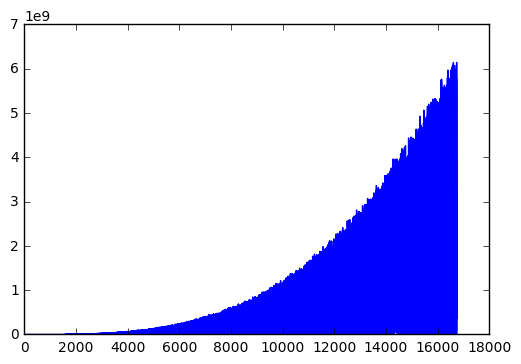

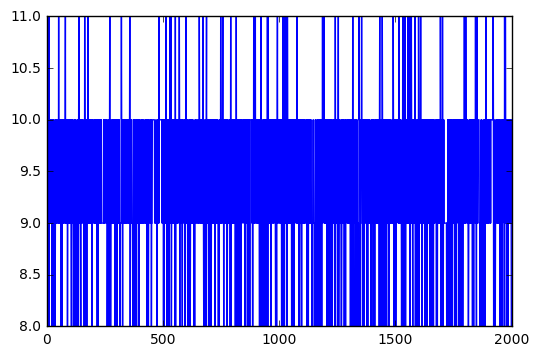

In [74]:
# Init tensorflow
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
env = gym.make('CartPole-v0')

loss_log = []
r_sum_log = []

for episode in range(2000):
    s = env.reset()
    r_sum = 0
    for step in range(200):
        prob = sess.run(tf_prob, feed_dict={tf_obs_a:[s]})[0]
        action = np.random.choice([0, 1], p=prob)
        #action = np.random.choice([0, 1], p=[0.5,0.5])
        s1, r, d, info = env.step(action)
        r_sum += r
        
        #env.render()
        if not d:
            # Training
            maxQ1 = sess.run(outQ_c, feed_dict={tf_obs_c:[s1]})
            
            targetQ = r + gamma * maxQ1
            
            Qsa, td_error = sess.run([tf_Qsa, tf_td_error], feed_dict={tf_obs_c:[s],
                                                                      tf_action:np.array([[action]]),
                                                                      tf_targetQ:np.array([[targetQ]])})
            sess.run(trainer_a, feed_dict={tf_obs_a:[s],
                                           tf_advantage_a:td_error,
                                           tf_Qsa_a:np.array([[Qsa]]),
                                           tf_action:np.array([[action]])})
            
            _, loss = sess.run([trainer_c, loss_c], feed_dict={tf_obs_c:[s], 
                                                               tf_action:np.array([[action]]), 
                                                               tf_targetQ:np.array([[targetQ]])})
            loss_log.append(loss)
            # Update Action Network

        else:
            break
        s = s1
    r_sum_log.append(r_sum)
plt.plot(loss_log)
plt.show()
plt.plot(r_sum_log)
plt.show()

In [77]:
targetQ

966833.3125

0

In [76]:
sess.run(W1_c)

array([[ -8.93382950e+01,  -4.24214602e-01,   1.81846693e-01,
          9.51386690e-01,  -8.78677673e+01,  -1.04866207e+00,
         -9.03140259e+01,  -8.73449783e+01,   1.01039779e+00,
         -8.91806641e+01],
       [ -2.05071930e+02,   6.63307130e-01,   2.44530988e+00,
          1.20921314e+00,  -2.05991821e+02,  -8.13305318e-01,
         -2.03380966e+02,  -2.05443771e+02,   1.36250806e+00,
         -2.05603317e+02],
       [  1.11986893e+02,   1.90917385e+00,  -7.38256931e-01,
         -1.02379930e+00,   1.13952309e+02,  -5.35835564e-01,
          1.13205147e+02,   1.11879822e+02,  -5.47010362e-01,
          1.12392273e+02],
       [  2.05120651e+02,  -2.21196160e-01,  -2.39450049e+00,
          1.05068159e+00,   2.05248199e+02,  -5.01435101e-01,
          2.04146469e+02,   2.06218704e+02,   2.90991217e-01,
          2.03767731e+02]], dtype=float32)

In [15]:
for episode in range(10):
    env.reset()
    action = env.action_space.sample()
    s, r, d, info = env.step(action)
    for step in range(200):
        prob = sess.run(tf_prob, feed_dict={tf_obs_a:s[np.newaxis,:]})[0]
        action = np.random.choice([0, 1], p=prob)
        s, r, d, info = env.step(action)
        env.render()
        if d:
            break